# Historical monitoring

Checking values from NHC and CHIRPS-GEFS historical forecasts 

In [10]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
import ocha_stratus as stratus
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from tqdm.auto import tqdm

from src.datasources import nhc, ibtracs, chirps_gefs, zma

In [17]:
gdf_zma = zma.load_zma()

In [39]:
df_gefs = chirps_gefs.load_processed_chirps_gefs()

In [40]:
df_gefs

,valid_date,issued_date,variable,value
0,2000-01-14,2000-01-14,q50,NaN
1,2000-01-15,2000-01-14,q50,1.209408
2,2000-01-16,2000-01-14,q50,1.236285
3,2000-01-17,2000-01-14,q50,0.665531
4,2000-01-18,2000-01-14,q50,0.379644
...,...,...,...,...
422411,2012-02-01,2012-01-21,q50,0.638420
422412,2012-02-02,2012-01-21,q50,0.387193
422413,2012-02-03,2012-01-21,q50,0.568920
422414,2012-02-04,2012-01-21,q50,0.886609


In [14]:
# replace with load
df_nhc = nhc.load_historical_forecasts()

In [22]:
gdf_nhc = gpd.GeoDataFrame(
    data=df_nhc,
    geometry=gpd.points_from_xy(df_nhc["lon"], df_nhc["lat"]),
    crs=4326,
)

In [23]:
gdf_nhc["in_zma"] = gdf_nhc.within(gdf_zma.iloc[0].geometry)

In [33]:
gdf_nhc

,issue_time,valid_time,lat,lon,windspeed,pressure,atcf_id,geometry,in_zma
0,2000-06-07 18:00:00,2000-06-08 06:00:00,21.8,-93.5,25,0,al012000,POINT (-93.5 21.8),False
1,2000-06-07 18:00:00,2000-06-08 18:00:00,22.5,-93.7,30,0,al012000,POINT (-93.7 22.5),False
2,2000-06-07 18:00:00,2000-06-09 06:00:00,23.0,-94.0,35,0,al012000,POINT (-94 23),False
3,2000-06-07 18:00:00,2000-06-09 18:00:00,23.5,-94.5,35,0,al012000,POINT (-94.5 23.5),False
4,2000-06-07 18:00:00,2000-06-10 18:00:00,25.5,-96.0,35,0,al012000,POINT (-96 25.5),False
...,...,...,...,...,...,...,...,...,...
78692,2024-11-18 00:00:00,2024-11-18 12:00:00,19.3,-92.0,20,0,al192024,POINT (-92 19.3),False
78693,2024-11-18 06:00:00,2024-11-18 06:00:00,18.5,-91.1,25,0,al192024,POINT (-91.1 18.5),False
78694,2024-11-18 06:00:00,2024-11-18 09:00:00,19.0,-91.5,25,1005,al192024,POINT (-91.5 19),False
78695,2024-11-18 06:00:00,2024-11-18 18:00:00,20.3,-92.4,20,0,al192024,POINT (-92.4 20.3),False


In [36]:
gdf_nhc_zma = gdf_nhc[gdf_nhc["in_zma"]]

In [47]:
df_gefs_v

,valid_date,issued_date,variable,value
190370,2005-06-10,2005-06-08,q50,41.165604
190371,2005-06-11,2005-06-08,q50,22.532120
190386,2005-06-10,2005-06-08,q80,60.305435
190387,2005-06-11,2005-06-08,q80,37.470634
190402,2005-06-10,2005-06-08,q90,72.242355
190403,2005-06-11,2005-06-08,q90,43.249320
190418,2005-06-10,2005-06-08,q95,86.469055
190419,2005-06-11,2005-06-08,q95,47.836594
190434,2005-06-10,2005-06-08,q99,117.416860
190435,2005-06-11,2005-06-08,q99,57.667873


In [59]:
lt_group

,issue_time,valid_time,lat,lon,windspeed,pressure,atcf_id,geometry,in_zma
13686,2005-06-08 18:00:00,2005-06-10 06:00:00,22.2,-85.1,45,0,al012005,POINT (-85.1 22.2),True


In [62]:
dicts = []

lts = {
    "readiness": pd.Timedelta(days=5),
    "action": pd.Timedelta(days=3),
}

for atcf_id, storm_group in tqdm(gdf_nhc_zma.groupby("atcf_id")):
    for issue_time, issue_group in storm_group.groupby("issue_time"):
        df_gefs_i = df_gefs[df_gefs["issued_date"] == issue_time.date()]
        for lt_name, lt in lts.items():
            lt_group = issue_group[
                issue_group["valid_time"] <= issue_time + lt
            ]
            start_date = lt_group["valid_time"].min().date()
            end_date = lt_group["valid_time"].max().date() + pd.Timedelta(
                days=1
            )
            df_gefs_v = df_gefs_i[
                (df_gefs_i["valid_date"] >= start_date)
                & (df_gefs_i["valid_date"] <= end_date)
            ]
            dict_out = df_gefs_v.groupby("variable")["value"].max().to_dict()
            dict_out.update(
                {
                    "atcf_id": atcf_id,
                    "issue_time": issue_time,
                    "lt_name": lt_name,
                    "wind": lt_group["windspeed"].max(),
                }
            )
            dicts.append(dict_out)

  0%|          | 0/82 [00:00<?, ?it/s]

In [63]:
df_monitors = pd.DataFrame(dicts)

In [64]:
df_monitors

,mean,q50,q80,q90,q95,q99,atcf_id,issue_time,lt_name,wind
0,44.380985,41.165604,60.305435,72.242355,86.469055,117.41686,al012005,2005-06-08 18:00:00,readiness,45.0
1,44.380985,41.165604,60.305435,72.242355,86.469055,117.41686,al012005,2005-06-08 18:00:00,action,45.0
2,52.950157,47.856190,71.045200,91.562890,115.904170,149.36382,al012005,2005-06-09 00:00:00,readiness,35.0
3,52.950157,47.856190,71.045200,91.562890,115.904170,149.36382,al012005,2005-06-09 00:00:00,action,35.0
4,52.950157,47.856190,71.045200,91.562890,115.904170,149.36382,al012005,2005-06-09 06:00:00,readiness,40.0
...,...,...,...,...,...,...,...,...,...,...
1823,NaN,NaN,NaN,NaN,NaN,NaN,al292020,2020-11-10 12:00:00,action,55.0
1824,NaN,NaN,NaN,NaN,NaN,NaN,al292020,2020-11-10 18:00:00,readiness,50.0
1825,NaN,NaN,NaN,NaN,NaN,NaN,al292020,2020-11-10 18:00:00,action,50.0
1826,NaN,NaN,NaN,NaN,NaN,NaN,al292020,2020-11-11 00:00:00,readiness,55.0


In [93]:
df_monitors_max = (
    df_monitors.groupby(["atcf_id", "lt_name"]).max().reset_index().dropna()
)

In [94]:
df_monitors_max

,atcf_id,lt_name,mean,q50,q80,q90,q95,q99,issue_time,wind
0,al012005,action,52.950157,47.856190,71.045200,91.562890,115.904170,149.363820,2005-06-10 12:00:00,50.0
1,al012005,readiness,52.950157,47.856190,71.045200,91.562890,115.904170,149.363820,2005-06-10 12:00:00,50.0
2,al012006,action,33.027378,8.143184,70.166730,114.015564,131.700010,168.528820,2006-06-10 18:00:00,35.0
3,al012006,readiness,33.027378,8.143184,70.166730,114.015564,131.700010,168.528820,2006-06-10 18:00:00,35.0
8,al022009,action,13.270083,11.928123,18.099740,24.026773,29.061850,39.484074,2009-08-17 12:00:00,30.0
...,...,...,...,...,...,...,...,...,...,...
153,al252005,readiness,41.724910,19.985786,70.906010,141.224580,164.415220,211.634300,2005-10-24 00:00:00,135.0
154,al262005,action,11.827251,7.242763,14.412372,22.866184,47.838630,96.984566,2005-10-23 18:00:00,35.0
155,al262005,readiness,11.827251,7.242763,14.412372,22.866184,47.838630,96.984566,2005-10-23 18:00:00,35.0
158,al282005,action,1.724343,0.803031,3.099219,5.081104,6.967461,10.931944,2005-11-20 00:00:00,45.0


In [115]:
df_monitors_max["year"] = df_monitors_max["atcf_id"].str[-4:].astype(int)

In [116]:
df_monitors_max

,atcf_id,lt_name,mean,q50,q80,q90,q95,q99,issue_time,wind,year
0,al012005,action,52.950157,47.856190,71.045200,91.562890,115.904170,149.363820,2005-06-10 12:00:00,50.0,2005
1,al012005,readiness,52.950157,47.856190,71.045200,91.562890,115.904170,149.363820,2005-06-10 12:00:00,50.0,2005
2,al012006,action,33.027378,8.143184,70.166730,114.015564,131.700010,168.528820,2006-06-10 18:00:00,35.0,2006
3,al012006,readiness,33.027378,8.143184,70.166730,114.015564,131.700010,168.528820,2006-06-10 18:00:00,35.0,2006
8,al022009,action,13.270083,11.928123,18.099740,24.026773,29.061850,39.484074,2009-08-17 12:00:00,30.0,2009
...,...,...,...,...,...,...,...,...,...,...,...
153,al252005,readiness,41.724910,19.985786,70.906010,141.224580,164.415220,211.634300,2005-10-24 00:00:00,135.0,2005
154,al262005,action,11.827251,7.242763,14.412372,22.866184,47.838630,96.984566,2005-10-23 18:00:00,35.0,2005
155,al262005,readiness,11.827251,7.242763,14.412372,22.866184,47.838630,96.984566,2005-10-23 18:00:00,35.0,2005
158,al282005,action,1.724343,0.803031,3.099219,5.081104,6.967461,10.931944,2005-11-20 00:00:00,45.0,2005


In [95]:
n_years = (
    df_monitors_max["issue_time"].max().year
    - df_monitors_max["issue_time"].min().year
    + 1
)

In [96]:
target_rps = {
    "action": 3.7,
    "readiness": 3,
}

In [106]:
target_trig_years = {
    lt_name: int((n_years + 1) / rp) for lt_name, rp in target_rps.items()
}

In [108]:
target_trig_years

{'action': 3, 'readiness': 4}

In [128]:
[x for x in df_monitors_max.columns if "q" in x or x == "mean"]

['mean', 'q50', 'q80', 'q90', 'q95', 'q99']

In [132]:
rain_cols = [x for x in df_monitors_max.columns if "q" in x or x == "mean"]

dicts = []

for lt_name, lt_trig_years in target_trig_years.items():
    for wind_thresh in df_monitors_max["wind"].unique():
        for rain_thresh in df_monitors_max[rain_col].unique():
            for rain_col in rain_cols:
                dff = df_monitors_max[
                    (df_monitors_max["wind"] >= wind_thresh)
                    & (df_monitors_max[rain_col] >= rain_thresh)
                ]
                if dff["year"].nunique() == lt_trig_years:
                    dicts.append(
                        {
                            "lt_name": lt_name,
                            "wind_thresh": wind_thresh,
                            "rain_thresh": rain_thresh,
                            "rain_col": rain_col,
                        }
                    )

In [133]:
df_threshs = pd.DataFrame(dicts)

In [141]:
df_plot

,lt_name,wind_thresh,rain_thresh,rain_col
1,action,50.0,61.112644,mean
6,action,50.0,59.534355,mean
9,action,50.0,60.433970,mean
16,action,35.0,65.143936,mean
18,action,35.0,64.565580,mean
...,...,...,...,...
1052,readiness,120.0,41.262890,mean
1066,readiness,120.0,42.730686,mean
1072,readiness,120.0,13.506035,mean
1094,readiness,120.0,17.215923,mean


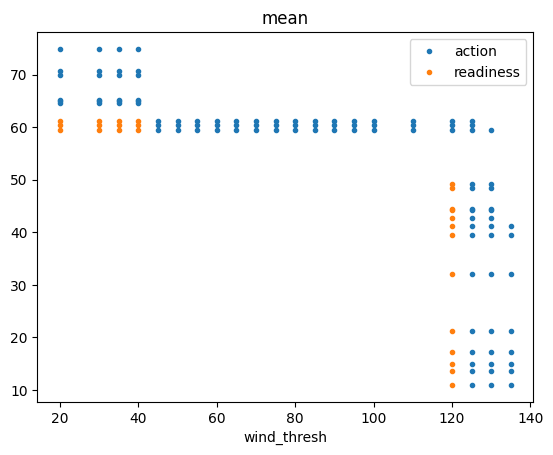

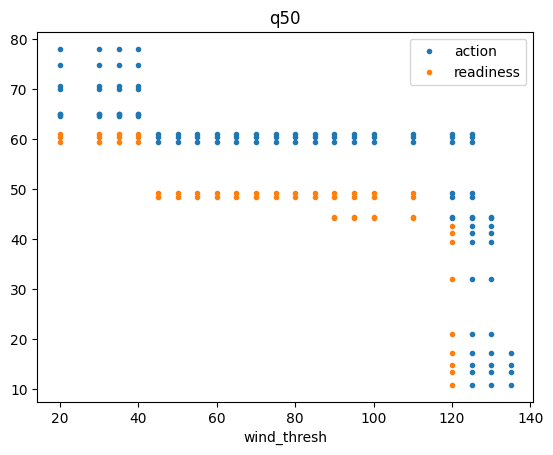

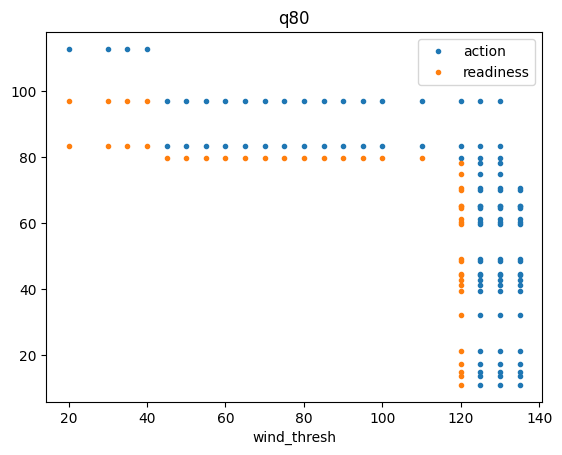

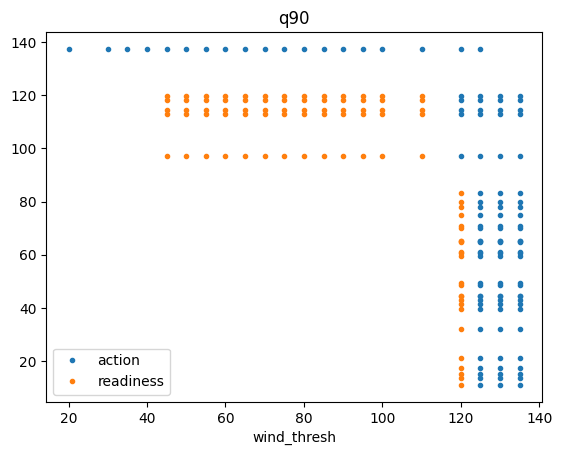

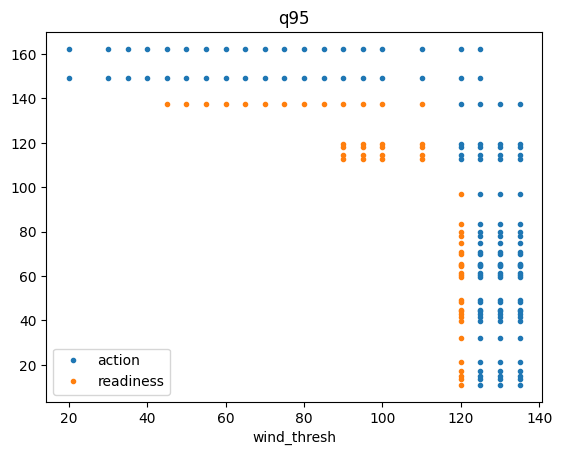

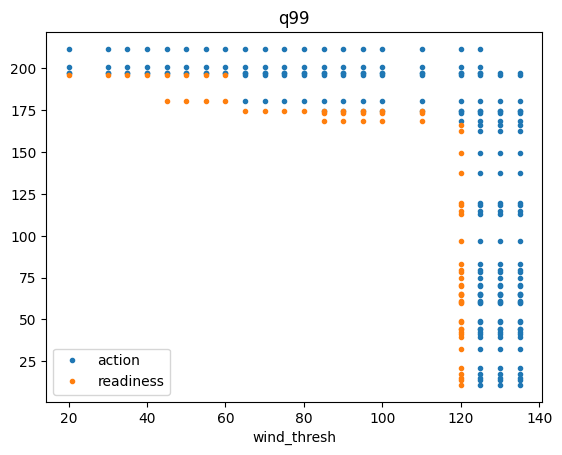

In [150]:
df_plot = df_threshs[df_threshs["rain_col"] == "mean"]

for rain_col, rain_group in df_threshs.groupby("rain_col"):
    fig, ax = plt.subplots()
    ax.set_title(rain_col)
    for lt_name, group in rain_group.groupby("lt_name"):
        group.plot(
            x="wind_thresh",
            y="rain_thresh",
            ax=ax,
            label=lt_name,
            linewidth=0,
            marker=".",
        )

In [137]:
df_plot.plot()

,lt_name,wind_thresh,rain_thresh,rain_col
1,action,50.0,61.112644,mean
6,action,50.0,59.534355,mean
9,action,50.0,60.433970,mean
16,action,35.0,65.143936,mean
18,action,35.0,64.565580,mean
...,...,...,...,...
1052,readiness,120.0,41.262890,mean
1066,readiness,120.0,42.730686,mean
1072,readiness,120.0,13.506035,mean
1094,readiness,120.0,17.215923,mean
